# Setup

In [1]:
from google.colab import drive
import os

# Parameters
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/Online Implementations/ViT/APTOS2019'

drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

Mounted at /content/drive
CWD: /content/drive/My Drive/University Of Stirling/Dissertation/Online Implementations/ViT/APTOS2019


In [2]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [4]:
import math
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('train.csv')
    
    train_dir = os.path.join('./','train_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
  
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train

df_train = load_data()
print(df_train.shape,'\n')

df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2)


(3662, 4) 



In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [8]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=batch_size,
                                                      class_mode="categorical",
                                                      target_size=(image_size, image_size),
                                                      subset='training')
    
    test_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=batch_size,
                                                      class_mode="categorical",    
                                                      target_size=(image_size, image_size),
                                                      subset='validation')
    
    return train_generator, test_generator

In [9]:
train_generator, test_generator = img_generator(df_train_train,df_train_test)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 592 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1870 validated image filenames belonging to 5 classes.
Found 467 validated image filenames belonging to 5 classes.


In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [23]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


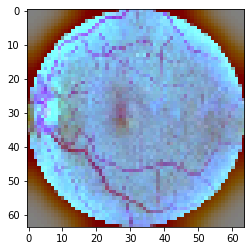

tf.Tensor(
[[[[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.4901961 ]
   ...
   [0.5019608  0.5019608  0.4901961 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.48627454]
   [0.5019608  0.5019608  0.48627454]
   ...
   [0.5019608  0.5019608  0.48627454]
   [0.5019608  0.5019608  0.48627454]
   [0.5019608  0.5019608  0.5019608 ]]

  ...

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.48627454]
   ...
   [0.5019608  0.5019608  0.48627454]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  [[0.5019608  0.5019608  0.501960

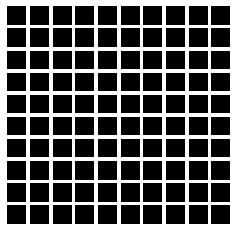

In [14]:
import matplotlib.pyplot as plt

img, label = train_generator.next()

image = img[0]
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.show()

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


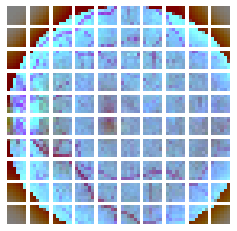

In [26]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img)
    plt.axis("off")